In [2]:
# Incluir definición de parámetros
%run -i '/content/drive/MyDrive/TFM/0.config.py'

Usando DS_FILE       : /content/drive/MyDrive/TFM/etherdata-MINUTE-2021-09-01-2021-11-30.csv
Usando DS_FILE_CLEAN : /content/drive/MyDrive/TFM/etherdata-MINUTE-2021-09-01-2021-11-30-CLEAN.csv


In [3]:
# Parámetros de la Ventana Deslizante
# INPUT_LEN   : Número de muestras de la entrada (inputs)
# OFFSET      : Muestras de offset hasta el inicio de la salida
# OUTPUT_LEN  : Número de muestras de la salida (labels)

INPUT_HOURS=12
OFFSET_HOURS=1

# Calcular la frecuencia por día
if TIME_PREFIX == 'HOUR': 
  INPUT_LEN  = INPUT_HOURS  
  OFFSET     = OFFSET_HOURS
  OUTPUT_LEN = 1

elif TIME_PREFIX == '5MINUTE': 
  INPUT_LEN  = INPUT_HOURS *12   # 12 periodos de 5 min / hr
  OFFSET     = OFFSET_HOURS*12    
  OUTPUT_LEN = 1

elif TIME_PREFIX == 'MINUTE': 
  INPUT_LEN  = INPUT_HOURS *60   # 60 mins / hr
  OFFSET     = OFFSET_HOURS*60    
  OUTPUT_LEN = 1

else:
  print ('Error')

print('Usando entrada: '+str(INPUT_LEN)+' muestras, offset: '+str(OFFSET)+' muestras. Periodo: '+str(TIME_PREFIX))

# Valor a predecir
LABEL = 'min_gas_price'

Usando entrada: 720 muestras, offset: 60 muestras. Periodo: MINUTE


In [4]:

# Importaciones
from google.colab import auth
from google.cloud import bigquery

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy import stats

print(tf.__version__)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.7.0


In [5]:
# Cargar Dataframe de Google Drive
df_org = pd.read_csv(DS_FILE)


# **Revisar y Limpiar Datos**

In [6]:
# Convertir blk_timestamp de  tipo object a timestamp
df_org['time'] =  df_org['time'].apply (pd.to_datetime)

# Eliminar columna 'Unnamed: 0'
df_org=df_org.drop(columns=['Unnamed: 0'])

Buscar y eliminar filas con datos faltantes

In [7]:
# Ordenar columnas
df_org = df_org[['time','avg_gas_price','min_gas_price','max_gas_price','avg_base_fee_per_gas','avg_difficulty','avg_gas_limit','avg_gas_used','avg_size','avg_transaction_count','sum_tx_ether','num_blk','num_trn']]


In [8]:
df_org.isna().sum()

time                      0
avg_gas_price            11
min_gas_price            11
max_gas_price            11
avg_base_fee_per_gas      0
avg_difficulty            0
avg_gas_limit             0
avg_gas_used              0
avg_size                  0
avg_transaction_count     0
sum_tx_ether             11
num_blk                   0
num_trn                  11
dtype: int64

In [9]:
# Eliminar columna max_gas_price  
_ = df_org.pop('max_gas_price')

In [10]:
# Eliminar columna avg_base_fee_per_gas si necesario  
if DROP_avg_base_fee_per_gas :
  _ = df_org.pop('avg_base_fee_per_gas')


In [11]:
# Eliminar filas con elementos vacíos
df_org = df_org.dropna()

In [12]:
# Separar indice de tiempos
times = df_org.pop('time')

In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129716 entries, 0 to 129726
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   avg_gas_price          129716 non-null  float64
 1   min_gas_price          129716 non-null  float64
 2   avg_base_fee_per_gas   129716 non-null  float64
 3   avg_difficulty         129716 non-null  float64
 4   avg_gas_limit          129716 non-null  float64
 5   avg_gas_used           129716 non-null  float64
 6   avg_size               129716 non-null  float64
 7   avg_transaction_count  129716 non-null  float64
 8   sum_tx_ether           129716 non-null  float64
 9   num_blk                129716 non-null  int64  
 10  num_trn                129716 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 11.9 MB


In [14]:
df_org.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_gas_price,129716.0,1.264246e+02,1.766149e+02,3.123343e+01,8.177163e+01,1.120963e+02,1.489301e+02,4.936640e+04
min_gas_price,129716.0,9.980102e+01,7.194226e+01,2.201610e+01,6.428106e+01,8.963541e+01,1.208030e+02,7.000000e+03
avg_base_fee_per_gas,129716.0,1.074343e+02,6.739843e+01,2.381943e+01,6.972512e+01,9.698422e+01,1.301921e+02,3.574540e+03
avg_difficulty,129716.0,9.825380e+15,8.617930e+14,8.105268e+15,9.085683e+15,9.644141e+15,1.056607e+16,1.198155e+16
avg_gas_limit,129716.0,3.000432e+07,3.303342e+04,2.982056e+07,2.999267e+07,3.000325e+07,3.001465e+07,3.025857e+07
avg_gas_used,129716.0,1.680461e+07,5.206880e+06,2.027710e+05,1.323760e+07,1.555218e+07,1.897446e+07,3.019604e+07
avg_size,129716.0,8.133269e+01,3.181571e+01,1.340000e+00,5.998467e+01,7.410155e+01,9.522142e+01,8.072114e+02
avg_transaction_count,129716.0,2.157727e+02,8.366629e+01,2.250000e+00,1.605714e+02,1.960000e+02,2.487500e+02,1.424000e+03
sum_tx_ether,129716.0,1.404892e+03,6.788365e+03,0.000000e+00,3.318441e+02,5.845020e+02,1.156248e+03,1.000184e+06
num_blk,129716.0,4.482169e+00,1.977930e+00,1.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00,1.600000e+01


# **Buscar y eliminar outliers**

In [15]:
# Preservamos el df original
df = df_org

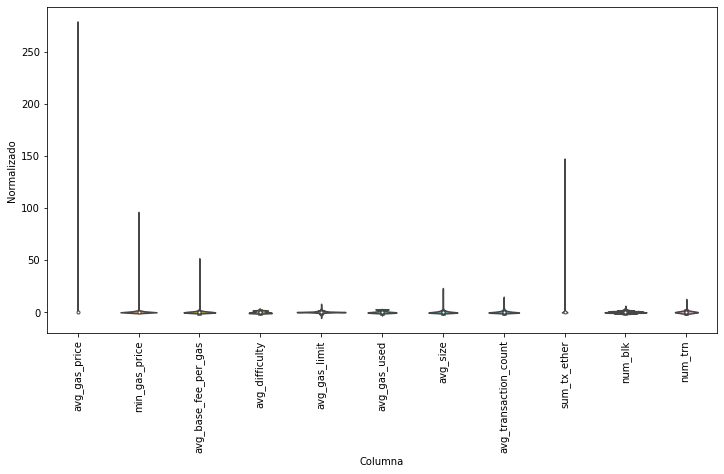

In [16]:
# Representar datos normalizados 
mean = df.mean()
std  = df.std()
df_normed = (df - mean) / std

df_toplot = df_normed.melt(var_name='Columna', value_name='Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizado', data=df_toplot)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [17]:
print ("mean df: ", mean)
print ("var  df: ", std)

mean df:  avg_gas_price            1.264246e+02
min_gas_price            9.980102e+01
avg_base_fee_per_gas     1.074343e+02
avg_difficulty           9.825380e+15
avg_gas_limit            3.000432e+07
avg_gas_used             1.680461e+07
avg_size                 8.133269e+01
avg_transaction_count    2.157727e+02
sum_tx_ether             1.404892e+03
num_blk                  4.482169e+00
num_trn                  8.747685e+02
dtype: float64
var  df:  avg_gas_price            1.766149e+02
min_gas_price            7.194226e+01
avg_base_fee_per_gas     6.739843e+01
avg_difficulty           8.617930e+14
avg_gas_limit            3.303342e+04
avg_gas_used             5.206880e+06
avg_size                 3.181571e+01
avg_transaction_count    8.366629e+01
sum_tx_ether             6.788365e+03
num_blk                  1.977930e+00
num_trn                  3.380424e+02
dtype: float64


In [18]:
# Eliminar filas con valores fuera del rango MAX_ZSCORE
MAX_ZSCORE = 3

df = df_org # Recuperamos el original
filas1 = df.shape[0]
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < MAX_ZSCORE).all(axis=1)]
filas2 = df.shape[0]
print ("Filas eliminadas : ",filas1-filas2," de ", filas1, (filas1-filas2)/filas1*100, "%")

Filas eliminadas :  9044  de  129716 6.972154553023528 %


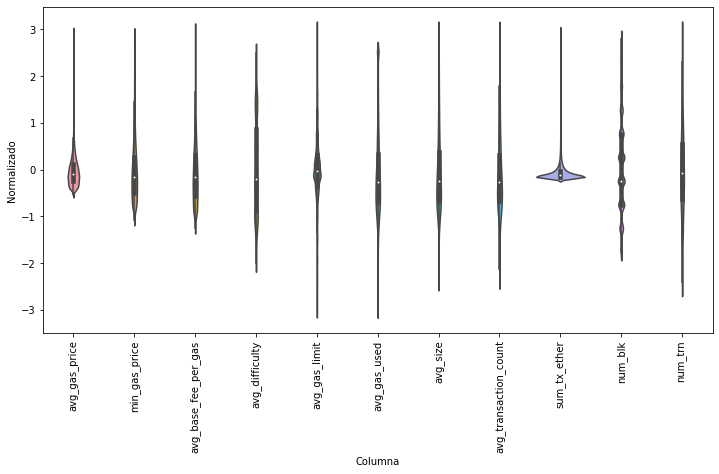

In [19]:
# Representar, de nuevo, datos normalizados 
#mean = df.mean()
#std  = df.std()
df_normed = (df - mean) / std

df_toplot = df_normed.melt(var_name='Columna', value_name='Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizado', data=df_toplot)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## **Dividir Datos en Train, Val y Test**

In [20]:
# Separar en datos de entrenamiento, validación y de test, en orden cronológico
n = len(df)

df_train  = df[0:int(n*0.7)]
df_val    = df[int(n*0.7):int(n*0.9)]
df_test   = df[int(n*0.9):]

num_features = df.shape[1]

In [21]:
print ("len df:       ", n)
print ("len df_train: ", len(df_train))
print ("len df_val:   ", len(df_val))
print ("len df_test:  ", len(df_test))
print ("num_features: ", num_features)

len df:        120672
len df_train:  84470
len df_val:    24134
len df_test:   12068
num_features:  11


In [22]:
df_train.head(5)

,avg_gas_price,min_gas_price,avg_base_fee_per_gas,avg_difficulty,avg_gas_limit,avg_gas_used,avg_size,avg_transaction_count,sum_tx_ether,num_blk,num_trn
0,144.200535,108.952305,123.899112,8.408211e+15,30011712.20,1.529858e+07,79.904600,177.800000,1330.632576,5,889.0
1,148.979721,122.558133,131.515493,8.404729e+15,30007323.75,2.020282e+07,140.132750,211.750000,1015.619942,4,847.0
3,171.618100,141.844955,153.041609,8.384228e+15,30029295.00,1.139280e+07,86.187250,133.000000,769.440098,4,532.0
4,159.572332,127.977873,134.559202,8.382809e+15,29994135.40,1.769249e+07,106.738000,178.400000,1053.739513,5,892.0
5,176.686208,146.946492,151.700486,8.368911e+15,30000000.00,1.221079e+07,83.654333,156.333333,803.862689,3,469.0


In [23]:
df_val.head()

,avg_gas_price,min_gas_price,avg_base_fee_per_gas,avg_difficulty,avg_gas_limit,avg_gas_used,avg_size,avg_transaction_count,sum_tx_ether,num_blk,num_trn
91199,203.542463,185.552050,185.552050,1.061761e+16,3.001005e+07,2.999786e+07,122.58100,388.000000,196.176137,1,388.0
91200,201.861701,176.224564,191.200339,1.061648e+16,2.998788e+07,1.122463e+07,49.75975,172.250000,449.510539,4,689.0
91201,194.010688,159.880248,176.899329,1.062015e+16,2.999233e+07,1.595301e+07,72.55140,250.800000,708.034014,5,1254.0
91202,182.984479,148.776187,165.424140,1.061932e+16,3.000657e+07,1.348515e+07,60.62550,208.333333,964.801537,6,1250.0
91203,175.634789,131.402738,149.472746,1.062401e+16,2.999232e+07,1.438113e+07,61.47980,200.800000,1412.021168,5,1004.0


## **Normalizar Datos**

Normalizamos los valores de la variables independientes, tal como debe hacerse en cualquier entrenamiento.

La normalización debe calcularse sólo sobre los datos de entrenamiento, y aplicarse la misma nornalización a todos los juegos de datos.


In [24]:
mean_train = df_train.mean()
std_train  = df_train.std()

df_train = (df_train - mean_train) / std_train
df_val   = (df_val   - mean_train) / std_train
df_test  = (df_test  - mean_train) / std_train


In [25]:
print ("mean df_train: ", mean_train)
print ("var  df_train: ", std_train)

mean df_train:  avg_gas_price            1.108128e+02
min_gas_price            8.745473e+01
avg_base_fee_per_gas     9.457229e+01
avg_difficulty           9.366670e+15
avg_gas_limit            3.001426e+07
avg_gas_used             1.648668e+07
avg_size                 8.194920e+01
avg_transaction_count    2.051663e+02
sum_tx_ether             1.112551e+03
num_blk                  4.538854e+00
num_trn                  8.557013e+02
dtype: float64
var  df_train:  avg_gas_price            5.362443e+01
min_gas_price            4.273841e+01
avg_base_fee_per_gas     4.579232e+01
avg_difficulty           5.327322e+14
avg_gas_limit            2.222077e+04
avg_gas_used             4.894928e+06
avg_size                 2.846357e+01
avg_transaction_count    6.986132e+01
sum_tx_ether             1.872067e+03
num_blk                  1.881293e+00
num_trn                  2.991239e+02
dtype: float64


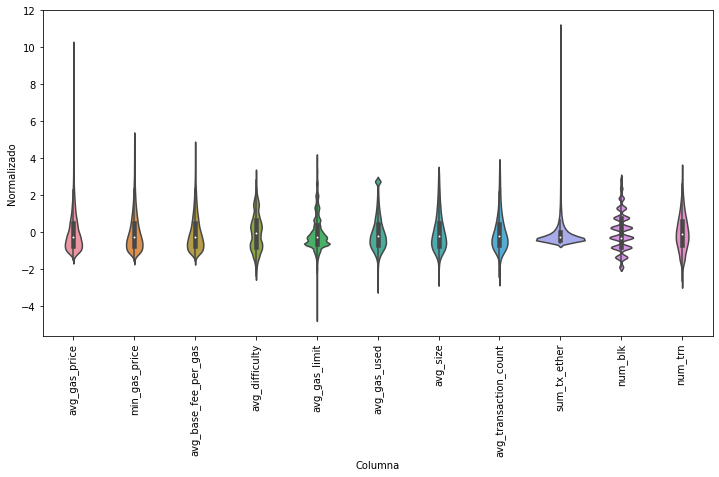

In [26]:
# Representar

df_toplot = df_train.melt(var_name='Columna', value_name='Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizado', data=df_toplot)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)

# **Clase WindowGenerator para generación de ventana deslizante**



In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None, default_plot_column=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    self.default_plot_column = default_plot_column

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift

    # inputs
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    # labels
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [29]:

def plot(self, model=None, plot_col=None, max_subplots=3):
  if plot_col is None:
    plot_col = self.default_plot_column 
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  
  # iterate plots
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    
    # plot inputs
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    # plot labels, if they exist
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    # plot predictions, if they exist
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    
    # write legend at first subplot
    if n == 0:
      plt.legend()
  # end iterate plots
  
  # write x-axis label
  plt.xlabel('[n]')

WindowGenerator.plot = plot

### 4. make_dataset to create `tf.data.Dataset`

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function:

In [30]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [31]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# **Crear ventana**

Total window size: 781
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

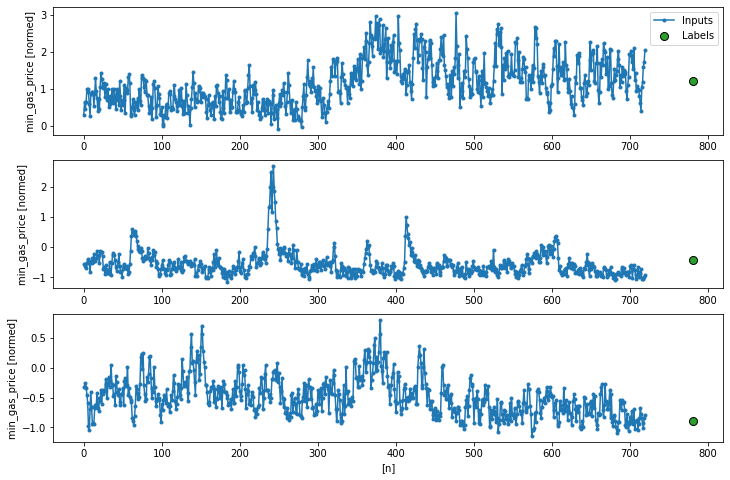

In [32]:
# Parámetros de la Ventana Deslizante
# INPUT_LEN   : Número de muestras de la entrada (inputs)
# OFFSET      : Muestras de offset hasta el inicio de la salida
# OUTPUT_LEN  : Número de muestras de la salida (labels)
# LABEL       : Feature a predecir

win = WindowGenerator(
    input_width=INPUT_LEN, label_width=OUTPUT_LEN, shift=OFFSET+OUTPUT_LEN,
    label_columns=[LABEL], default_plot_column=LABEL)

win.plot()
win

# **Baseline**

In [33]:
multi_val_performance = {}
multi_performance = {}

## LastBaseLine

In [34]:
class MultiStepLastBaseline(tf.keras.Model):
  def __init__(self, label_index):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    preds = inputs[:, -1:, self.label_index]
    return tf.tile(preds[:, :, tf.newaxis], [1, OUTPUT_LEN, 1])


730/730 [==============================] - 4s 5ms/step - loss: 0.5888 - mean_absolute_error: 0.5636 - mean_squared_error: 0.5888


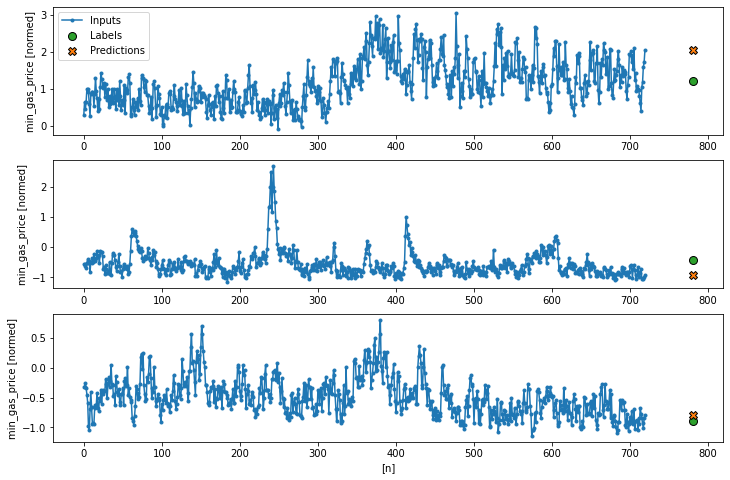

In [35]:
last_baseline = MultiStepLastBaseline(label_index=win.column_indices[LABEL])
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

multi_val_performance['Baseline'] = last_baseline.evaluate(win.val)
multi_performance['Baseline'] = last_baseline.evaluate(win.test, verbose=0)

win.plot(last_baseline, LABEL)

In [36]:
multi_performance['Baseline']

[0.7185811400413513, 0.6040863394737244, 0.7185811400413513]

In [37]:
multi_val_performance['Baseline']

[0.5887526273727417, 0.5635615587234497, 0.5887526273727417]

# **Definición de Fuciones de Entrenamiento**

In [38]:
# Función de compilación y entrenamiento
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [39]:
# Función para representar el histórico de entrenamientos
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,500])
  plt.legend()

  plt.show()

# **Lineal**

In [40]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUTPUT_LEN*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUTPUT_LEN, num_features])
])

history = compile_and_fit(multi_linear_model, win)


Epoch 1/20
2616/2616 [==============================] - 22s 8ms/step - loss: 0.5229 - mean_absolute_error: 0.4991 - mean_squared_error: 0.5229 - val_loss: 0.4369 - val_mean_absolute_error: 0.5015 - val_mean_squared_error: 0.4369
Epoch 2/20
2616/2616 [==============================] - 23s 9ms/step - loss: 0.5060 - mean_absolute_error: 0.4871 - mean_squared_error: 0.5060 - val_loss: 0.4384 - val_mean_absolute_error: 0.5028 - val_mean_squared_error: 0.4384
Epoch 3/20
2616/2616 [==============================] - 31s 12ms/step - loss: 0.5056 - mean_absolute_error: 0.4870 - mean_squared_error: 0.5056 - val_loss: 0.4390 - val_mean_absolute_error: 0.5026 - val_mean_squared_error: 0.4390
Epoch 4/20
2616/2616 [==============================] - 19s 7ms/step - loss: 0.5055 - mean_absolute_error: 0.4870 - mean_squared_error: 0.5055 - val_loss: 0.4387 - val_mean_absolute_error: 0.5023 - val_mean_squared_error: 0.4387
Epoch 5/20
2616/2616 [==============================] - 19s 7ms/step - loss: 0.5055

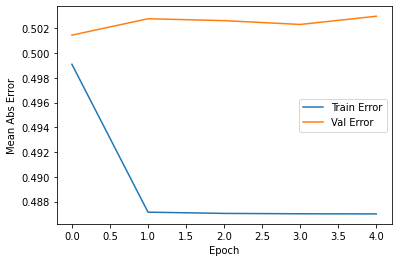

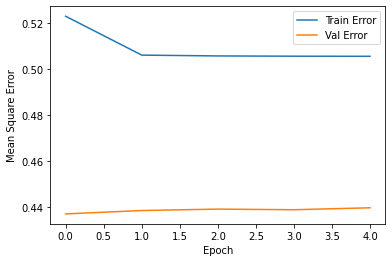

In [41]:
plot_history(history)

730/730 [==============================] - 4s 5ms/step - loss: 0.4396 - mean_absolute_error: 0.5030 - mean_squared_error: 0.4396


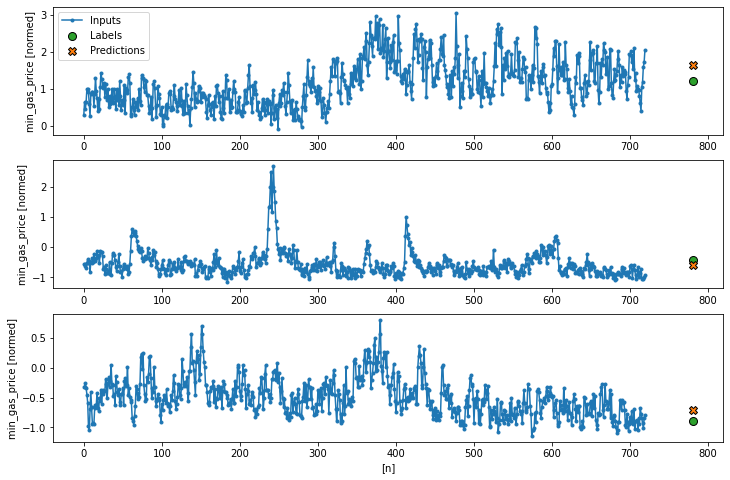

In [42]:
multi_val_performance['Lineal'] = multi_linear_model.evaluate(win.val)
multi_performance['Lineal'] = multi_linear_model.evaluate(win.test, verbose=0)

win.plot(multi_linear_model)

# **Red Neuronal Densa**

In [43]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUTPUT_LEN*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUTPUT_LEN, num_features])
])

history = compile_and_fit(multi_dense_model, win)



Epoch 1/20
2616/2616 [==============================] - 21s 8ms/step - loss: 0.4651 - mean_absolute_error: 0.4662 - mean_squared_error: 0.4651 - val_loss: 0.4208 - val_mean_absolute_error: 0.4854 - val_mean_squared_error: 0.4208
Epoch 2/20
2616/2616 [==============================] - 21s 8ms/step - loss: 0.4497 - mean_absolute_error: 0.4580 - mean_squared_error: 0.4497 - val_loss: 0.4292 - val_mean_absolute_error: 0.4849 - val_mean_squared_error: 0.4292
Epoch 3/20
2616/2616 [==============================] - 18s 7ms/step - loss: 0.4456 - mean_absolute_error: 0.4555 - mean_squared_error: 0.4456 - val_loss: 0.4232 - val_mean_absolute_error: 0.4829 - val_mean_squared_error: 0.4232
Epoch 4/20
2616/2616 [==============================] - 21s 8ms/step - loss: 0.4438 - mean_absolute_error: 0.4546 - mean_squared_error: 0.4438 - val_loss: 0.4214 - val_mean_absolute_error: 0.4817 - val_mean_squared_error: 0.4214
Epoch 5/20
2616/2616 [==============================] - 20s 8ms/step - loss: 0.4426 

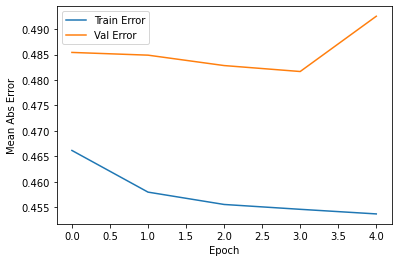

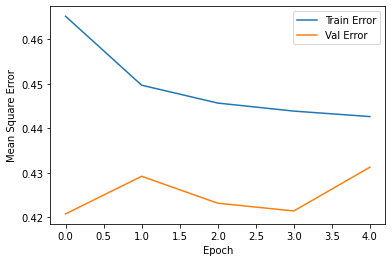

In [44]:
plot_history(history)

730/730 [==============================] - 4s 6ms/step - loss: 0.4312 - mean_absolute_error: 0.4925 - mean_squared_error: 0.4312


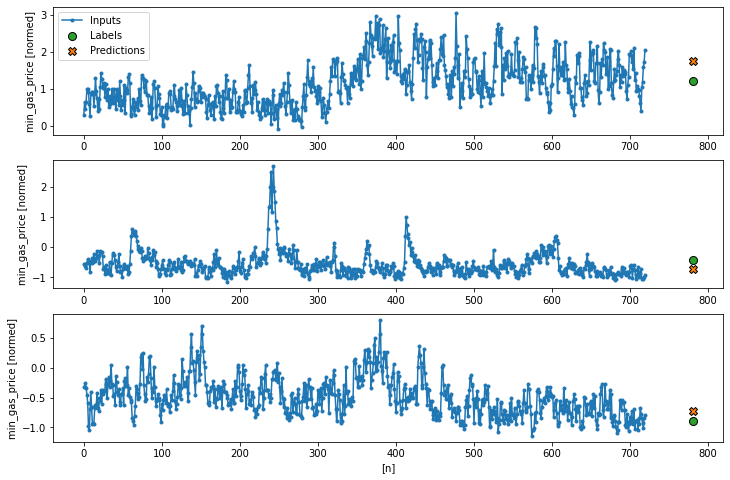

In [45]:
multi_val_performance['Perceptron'] = multi_dense_model.evaluate(win.val)
multi_performance['Perceptron'] = multi_dense_model.evaluate(win.test, verbose=0)
win.plot(multi_dense_model)

# **RNN**

In [46]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUTPUT_LEN*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUTPUT_LEN, num_features])
])

history = compile_and_fit(multi_lstm_model, win)



Epoch 1/20
2616/2616 [==============================] - 749s 285ms/step - loss: 0.4051 - mean_absolute_error: 0.4277 - mean_squared_error: 0.4051 - val_loss: 0.3883 - val_mean_absolute_error: 0.4620 - val_mean_squared_error: 0.3883
Epoch 2/20
2616/2616 [==============================] - 746s 285ms/step - loss: 0.3666 - mean_absolute_error: 0.4066 - mean_squared_error: 0.3666 - val_loss: 0.3844 - val_mean_absolute_error: 0.4519 - val_mean_squared_error: 0.3844
Epoch 3/20
2616/2616 [==============================] - 757s 289ms/step - loss: 0.3525 - mean_absolute_error: 0.4000 - mean_squared_error: 0.3525 - val_loss: 0.3759 - val_mean_absolute_error: 0.4577 - val_mean_squared_error: 0.3759
Epoch 4/20
2616/2616 [==============================] - 739s 282ms/step - loss: 0.3386 - mean_absolute_error: 0.3942 - mean_squared_error: 0.3386 - val_loss: 0.3955 - val_mean_absolute_error: 0.4759 - val_mean_squared_error: 0.3955
Epoch 5/20
2616/2616 [==============================] - 739s 282ms/step 

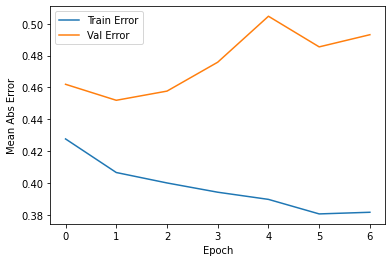

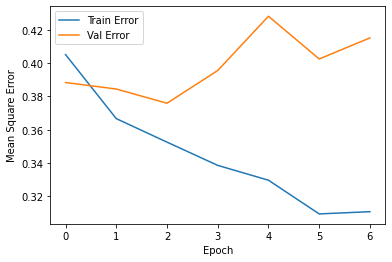

In [47]:
plot_history(history)

730/730 [==============================] - 47s 64ms/step - loss: 0.4151 - mean_absolute_error: 0.4931 - mean_squared_error: 0.4151


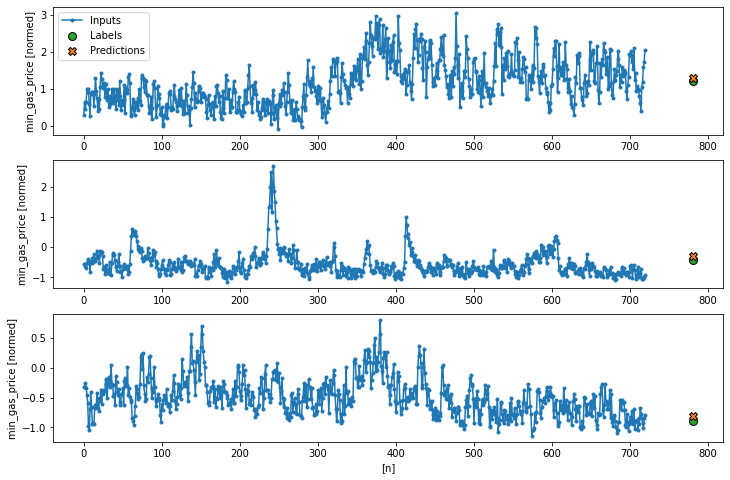

In [48]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(win.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(win.test, verbose=0)
win.plot(multi_lstm_model)

# **Performance**

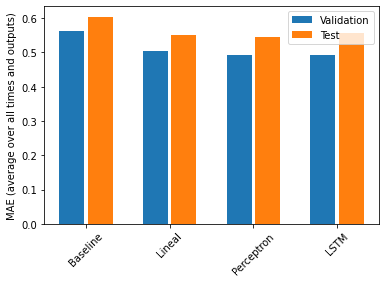

In [49]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()



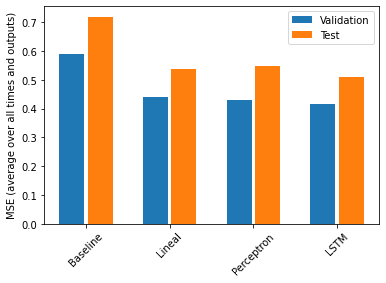

In [50]:

metric_name = 'mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()
